In [1]:
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with Hierarchical Target Encoded NAICS
Same as the baseline but include the hiearchical encoded NAICS

Copy of regular script 10, but with new blending ratio

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder # Target encoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet')) \
    .drop(columns='mhier_NAICS', errors='ignore')

#### Re-encode

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train']

In [8]:
encoder = HierarchicalEncoder(lambda_k = 100)

In [9]:
naics_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']

In [10]:
encoder.fit(train_df[naics_features], train_df['target'])

In [11]:
# Transform the data
enc_val = encoder.transform(sba_loans[naics_features]) \
    .rename('mhier_NAICS') \
    .to_frame()

In [12]:
# Save the values
pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=enc_val.columns, errors='ignore'), enc_val], axis = 1) \
    .to_parquet(Path(setup.temp_path).joinpath('X10_DATA_encodings.parquet'))

In [13]:
predictor_features = setup.predictor_features + ['mhier_NAICS']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'mhier_NAICS']


In [14]:
with open(Path(setup.temp_path).joinpath('X10_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

In [15]:
sba_loans = pd.concat([sba_loans.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
print(sba_loans.shape)

(688081, 58)


In [16]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

## Model Fit

In [17]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [18]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [20]:
xgb_model = xgb_model.set_params(**xgb_params)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50033	validation_1-logloss:0.50387
[1]	validation_0-logloss:0.49277	validation_1-logloss:0.49657
[2]	validation_0-logloss:0.48640	validation_1-logloss:0.49043
[3]	validation_0-logloss:0.48104	validation_1-logloss:0.48528
[4]	validation_0-logloss:0.47651	validation_1-logloss:0.48095
[5]	validation_0-logloss:0.47263	validation_1-logloss:0.47724
[6]	validation_0-logloss:0.46933	validation_1-logloss:0.47409
[7]	validation_0-logloss:0.46649	validation_1-logloss:0.47139
[8]	validation_0-logloss:0.46398	validation_1-logloss:0.46902
[9]	validation_0-logloss:0.46189	validation_1-logloss:0.46708
[10]	validation_0-logloss:0.46004	validation_1-logloss:0.46538
[11]	validation_0-logloss:0.45849	validation_1-logloss:0.46397
[12]	validation_0-logloss:0.45713	validation_1-logloss:0.46273
[13]	validation_0-logloss:0.45599	validation_1-logloss:0.46170
[14]	validation_0-logloss:0.45493	validation_1-logloss:0.46075
[15]	validation_0-logloss:0.45396	validation_1-logloss:0.45992
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [23]:
xgb_model.save_model(Path(setup.temp_path).joinpath('X10_MODEL_xgboost.json'))

In [24]:
with open(Path(setup.temp_path).joinpath('X10_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [25]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [26]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.184303,0.115585,0.015538,0.670782,0.167379
1,0.284655,0.112140,0.016175,0.674665,0.290685


## Decision Threshold
Max f1, on training data

In [27]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [28]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [29]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('X10_REPORT_thresh_tune.csv'), index=False)

In [30]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.454399
11,0.22,0.454041


##### Apply decision threshold
All datasets

In [31]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [32]:
pred_df['predict_bin'].value_counts()

predict_bin
0    409266
1    278815
Name: count, dtype: int64

In [33]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('X10_DATA_combined_predictions.parquet'))

## Metrics

In [34]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('X10_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.674506,0.441918,0.332671,0.658002,0.377037,0.731829,NaN
1,train,0.664313,0.454399,0.340440,0.683039,0.392932,0.735377,NaN
2,val,0.660261,0.450007,0.338802,0.669881,0.385627,0.726789,NaN
0,test,0.659708,0.449964,0.337038,0.676689,0.383260,0.728875,0.0
1,test,0.695766,0.428485,0.325281,0.627612,0.368452,0.733642,1.0


## Lift
Test data

In [35]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

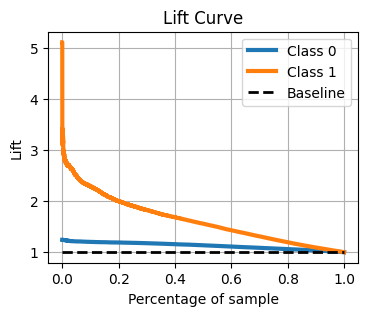

In [36]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('X10_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [37]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [38]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('X10_REPORT_importance_gain.csv'), index=True)

In [39]:
feat_impgain.head()

,importance
urban_flag,285.521698
LowDoc,117.915352
mhier_NAICS,97.526009
DisbursementGross,48.269917
franchise_flag,21.785601


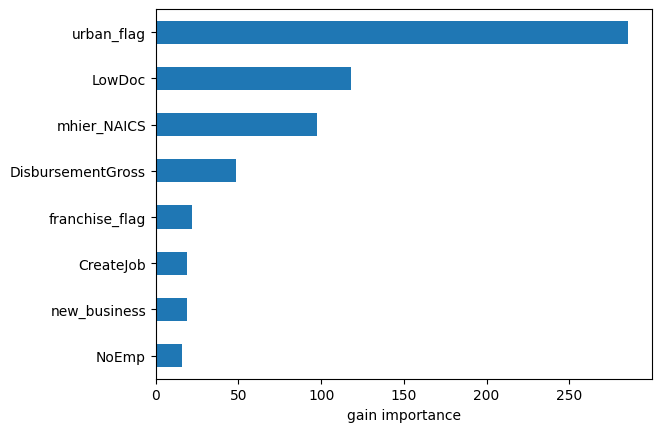

In [40]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('X10_PLOT_importance_gain.png'))

##### Permutation Importance

In [41]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [42]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [43]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,mhier_NAICS,0.084303,0.084303
3,DisbursementGross,0.066644,0.066644
5,urban_flag,0.034518,0.034518
1,CreateJob,0.020465,0.020465
2,LowDoc,0.014630,0.014630


In [44]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('X10_DATA_importance_perturb.csv'),
            index=False)

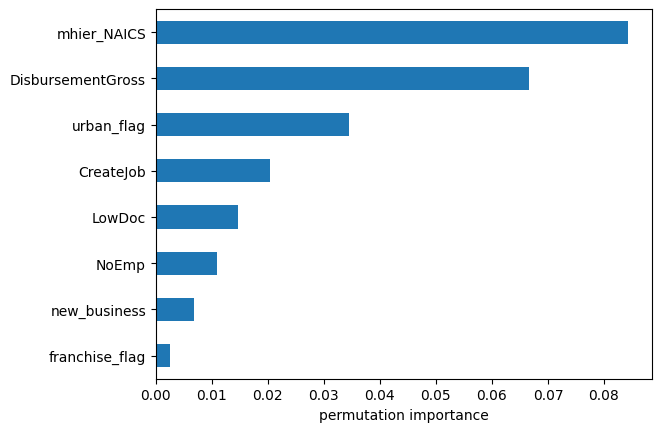

In [45]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('X10_PLOT_importance_perturb.png'))